# DATA

In [1]:
import numpy as np
import re
import string
import unicodedata
from unicodedata import normalize
import sys
import indicnlp
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.utils import plot_model
import numpy as np

In [2]:
def load_doc(filename):
    file = open('ENG_HIN_SMALL_DATASET.txt' , mode ='rt' , encoding = 'utf-8')
    text = file.read()
    file.close()
    return text

In [3]:
def to_pairs(text):
    lines = text.strip().split('\n') #1d list of strings
    eng_hin_pairs = [line.split('\t') for line in lines] #list
    eng_hin_pairs = np.delete(eng_hin_pairs , -1 , axis = 1)
    eng_hin_pairs = eng_hin_pairs.tolist()
    return eng_hin_pairs    

In [4]:
doc = load_doc('ENG_HIN_SMALL_DATASET.txt')
hin_eng_pairs = to_pairs(doc)
english_sentences = []
hindi_sentences = []
for i in range(len(hin_eng_pairs)):
    english_sentences.append(hin_eng_pairs[i][0])
    hindi_sentences.append(hin_eng_pairs[i][1])

### Cleaning english data

In [5]:
def clean_english_data(lines):
    re_print = re.compile('[^%s]' %re.escape(string.printable))
    table = str.maketrans('' , '' , string.punctuation)
    clean_eng_lines = []
    for line in lines:
        line = normalize('NFD' , line).encode('ascii' , 'ignore')
        line = line.decode('UTF-8')
        line = line.split()
        line = [word.lower() for word in line]
        line = [word.translate(table) for word in line]
        line = [re_print.sub('' , w) for w in line]
        line = [word for word in line if word.isalpha()]
        line = ' '.join(line)
        clean_eng_lines.append(line)
    return clean_eng_lines   

In [6]:
clean_eng_lines = clean_english_data(english_sentences)
print(type(clean_eng_lines))
print(english_sentences[0:10])
print(clean_eng_lines[0:10])

<class 'list'>
['Wow!', 'Help!', 'Jump.', 'Jump.', 'Jump.', 'Hello!', 'Hello!', 'Cheers!', 'Cheers!', 'Got it?']
['wow', 'help', 'jump', 'jump', 'jump', 'hello', 'hello', 'cheers', 'cheers', 'got it']


### Clean hindi data

###### SETTING UP PATHS FOR INDIC NLP

In [7]:
INDIC_NLP_LIB_HOME=r"C:\Users\sudha\Desktop\NMT_PROJECTS\Language_Translation_Chat_Bot\anoopkunchukuttan-indic_nlp_library-eccde81"
INDIC_NLP_RESOURCES=r"C:\Users\sudha\Desktop\NMT_PROJECTS\Language_Translation_Chat_Bot\indic_nlp_resources-master"
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize

In [8]:
def clean_text(line):
    text = line
    text = text.replace(u',' ,'')
    text = text.replace(u'"' ,'')
    text = text.replace(u'(' ,'')
    text = text.replace(u')' ,'')
    text = text.replace(u'"' ,'')
    text = text.replace(u':' ,'')
    text = text.replace(u"'" ,'')
    text = text.replace(u"'" ,'')
    text=text.replace(u"‘‘",'')
    text=text.replace(u"’’",'')
    text=text.replace(u"''",'')
    text=text.replace(u".",'')
    text=text.replace(u"-",'')
    text=text.replace(u"।",'')
    text=text.replace(u"?",'')
    text=text.replace(u"\\",'')
    text=text.replace(u"_",'')
    text = re.sub('[a-zA-Z]' , '' , text)
    text = re.sub('[0-9+\-*/.%&!]' , '' , text)
    return text

In [9]:
def clean_hindi_data(lines):
    clean_hin_lines = []
    for line in lines:
        remove_nuktas = False
        factory = IndicNormalizerFactory()
        normalizer = factory.get_normalizer("hi" , remove_nuktas = False )
        line = clean_text(line)
        tokens = list()
        for t in indic_tokenize.trivial_tokenize(line):
            tokens.append(t)
        line = tokens
        line = [ word.lower() for word in line]
        line = [word for word in line if not re.search(r'\d', word)]
        line = ' '.join(line)
        clean_hin_lines.append(line)
    return clean_hin_lines    

In [10]:
clean_hindi_lines = clean_hindi_data(hindi_sentences)
print(hindi_sentences[133])
print(clean_hindi_lines[133])

इसे दोबारा पढ़ें।
इसे दोबारा पढ़ें


### Adding SOS and EOS ,  PREPARING INPUTS FOR ENCODER AND DECODER

In [11]:
num_sentences = 2200 #(about 80-20 ratio)

In [12]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

In [13]:
#input sentences
input_sentences = clean_hindi_lines[0:num_sentences]

#output sentences
for line in clean_eng_lines[0:num_sentences]:
    line = line + ' <eos>'
    output_sentences.append(line)

#output sentence input

for line in clean_eng_lines[0:num_sentences]:
    line = '<sos> ' + line
    output_sentences_inputs.append(line)

In [14]:
output_sentences_inputs[0:10]

['<sos> wow',
 '<sos> help',
 '<sos> jump',
 '<sos> jump',
 '<sos> jump',
 '<sos> hello',
 '<sos> hello',
 '<sos> cheers',
 '<sos> cheers',
 '<sos> got it']

In [15]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 2200
num samples output: 2200
num samples output input: 2200


#### Tokenizing and padding  english and hindi

In [16]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [17]:
# for vocabulary

In [18]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<sos>'] = 0
#     self.word2idx['<eos>'] = 1
    
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word


In [19]:
pairs = []
for i in range(len(input_sentences)):
    pairs.append([])
    pairs[i].append(input_sentences[i])
    pairs[i].append(output_sentences_inputs[i])
    pairs[i].append(output_sentences[i])



In [20]:
output_sentences_inputs[0:10]

['<sos> wow',
 '<sos> help',
 '<sos> jump',
 '<sos> jump',
 '<sos> jump',
 '<sos> hello',
 '<sos> hello',
 '<sos> cheers',
 '<sos> cheers',
 '<sos> got it']

In [24]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(pairs):  
    inp_lang = LanguageIndex(hi for hi, en, en2 in pairs)
    targ_lang_decoder_input = LanguageIndex(en for hi, en, en2 in pairs)
#   targ_lang_decoder_output: english sentences with <eos>
    targ_lang_decoder_output = LanguageIndex(en2 for hi, en, en2 in pairs)
    input_tensor = [[inp_lang.word2idx[s] for s in hi.split(' ')] for hi, en, en2 in pairs]
    target_tensor = [[targ_lang_decoder_input.word2idx[s] for s in en.split(' ')] for hi, en, en2 in pairs]
    target_tensor_decoder_output = [[targ_lang_decoder_output.word2idx[s] for s in en2.split(' ')] for hi, en, en2 in pairs]
    max_length_inp, max_length_targ, max_length_target_decoder_output = max_length(input_tensor), max_length(target_tensor) , max_length(target_tensor_decoder_output)
    input_lang_vocab = inp_lang.vocab
    return inp_lang, targ_lang_decoder_input, targ_lang_decoder_output, max_length_inp, max_length_targ,max_length_target_decoder_output, input_tensor, target_tensor, target_tensor_decoder_output, input_lang_vocab






# def load_dataset(pairs):  
#     inp_lang = LanguageIndex(en for en, hi, hi2 in pairs)
#     targ_lang_decoder_input = LanguageIndex(hi for en, hi, hi2 in pairs)
# #   targ_lang_decoder_output: hindi sentences with <eos>
#     targ_lang_decoder_output = LanguageIndex(hi2 for en, hi, hi2 in pairs)
#     input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, hi, hi2 in pairs]
#     target_tensor = [[targ_lang_decoder_input.word2idx[s] for s in hi.split(' ')] for en, hi, hi2 in pairs]
#     target_tensor_decoder_output = [[targ_lang_decoder_output.word2idx[s] for s in hi2.split(' ')] for en, hi, hi2 in pairs]
#     max_length_inp, max_length_targ, max_length_target_decoder_output = max_length(input_tensor), max_length(target_tensor) , max_length(target_tensor_decoder_output)
#     input_lang_vocab = inp_lang.vocab
#     return inp_lang, targ_lang_decoder_input, targ_lang_decoder_output, max_length_inp, max_length_targ,max_length_target_decoder_output, input_tensor, target_tensor, target_tensor_decoder_output, input_lang_vocab




In [25]:
inp_lang, targ_lang_decoder_input, targ_lang_decoder_output, max_length_inp, max_length_targ ,max_length_target_decoder_output, input_tensor , target_tensor,target_tensor_decoder_output, input_lang_vocab = load_dataset(pairs)
# print(targ_lang_decoder_output.word2idx)
print(targ_lang_decoder_input.word2idx['<sos>'])
input_lang_word2idx = inp_lang.word2idx
word2idx_outputs = targ_lang_decoder_input.word2idx
num_words_output = len(word2idx_outputs) + 1
type(target_tensor)

1


list

In [26]:
# padding

In [27]:
def padded_tensor(max_length_inp, max_length_targ, input_tensor , target_tensor, target_tensor_decoder_output):
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='pre')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    encoder_input_sequences = pad_sequences(input_tensor, maxlen=max_length_inp,padding='pre')
    decoder_input_sequences = pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    target_tensor_decoder_output = pad_sequences(target_tensor_decoder_output, maxlen=max_length_target_decoder_output, padding='post')
    return input_tensor, target_tensor, target_tensor_decoder_output, encoder_input_sequences , decoder_input_sequences


In [28]:
input_tensor_train, target_tensor_train,target_tensor_decoder_output_train, encoder_input_sequences , decoder_input_sequences = padded_tensor(max_length_inp, max_length_targ, input_tensor , target_tensor, target_tensor_decoder_output)

In [29]:
input_tensor_train

array([[   0,    0,    0, ...,    0,    0, 1928],
       [   0,    0,    0, ...,    0,    0, 1393],
       [   0,    0,    0, ...,    0,    0,  182],
       ...,
       [   0,    0,    0, ..., 1270,  314, 2241],
       [   0,    0,    0, ..., 1737, 1560,  395],
       [   0,    0,    0, ..., 1470,   26, 2234]])

In [30]:
target_tensor_train

array([[   1, 1823,    0, ...,    0,    0,    0],
       [   1,  751,    0, ...,    0,    0,    0],
       [   1,  852,    0, ...,    0,    0,    0],
       ...,
       [   1, 1836, 1032, ...,  321,    0,    0],
       [   1, 1846,  689, ...,    2, 1607,    0],
       [   1, 1841,  537, ...,    0,    0,    0]])

### word embeddings

In [31]:
embeddings_dictionary = dict()
glove_file = open('hi-d100-glove.txt' ,  encoding = 'UTF-8', errors='ignore')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:] , dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [32]:
print(len(embeddings_dictionary))

1732951


In [33]:
num_words = min(MAX_NUM_WORDS, len(input_lang_vocab) + 1)
embedding_matrix = zeros((len(input_lang_vocab)+1, 100))
for word, index in input_lang_word2idx.items(): #input_lang_word2idx=1847
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
print(embedding_matrix[539])

[-0.94261402 -1.14529896  0.58091199 -0.72185099  0.62087101 -0.47525001
  0.51365501  0.47668201  0.225485   -0.017625    0.28595901  1.79291606
 -0.171185    0.76455897  0.140535   -0.75627202 -0.04815    -0.104546
  0.178875    0.506127    0.18240701  0.25192699 -0.25036901  0.33397901
  1.26716995 -0.130303   -0.17484599  2.49108696 -0.51533902 -0.082741
  0.98537701 -0.17586599  0.16473401 -0.65151    -0.013117    1.40071905
  0.002845   -0.41820499  0.204423   -1.18822598  0.201193    0.81549698
  0.21555001 -0.71363002 -0.885593    1.21263504  0.194709    1.21882796
 -0.20896401  0.53817397  0.371167   -0.090631   -0.74062598 -0.414121
  1.06668401  0.34387201  0.360897   -0.24086     0.27699399 -0.54655403
 -0.458722    0.110943   -0.91424799 -0.171417   -0.062431   -0.75383103
  0.94745702  0.31282401 -0.94324899 -0.066088   -0.29379499 -0.74771798
 -0.032092    1.12681103 -0.067055   -0.47093299 -0.25645     0.382983
 -0.24487799 -0.66938502  0.38157299 -0.18887199  0.396736 

In [35]:
print(len(embedding_matrix))

2255


In [36]:
embedding_layer = Embedding(num_words , EMBEDDING_SIZE , weights = [embedding_matrix] , input_length = max_length_inp)

# MODEL

## CREATING THE MODEL

In [37]:
decoder_targets_one_hot = np.zeros((len(input_sentences) , max_length_targ , num_words_output), dtype = 'float32')

In [38]:
decoder_targets_one_hot.shape

(2200, 11, 1848)

In [39]:
type(decoder_targets_one_hot)

numpy.ndarray

In [40]:
for i, d in enumerate(target_tensor_decoder_output_train):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [41]:
print(decoder_targets_one_hot[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## create the encoder and decoders

In [42]:
encoder_inputs_placeholder = Input(shape = (max_length_inp,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state = True)
encoder_outputs, h ,c = encoder(x)
encoder_states = [h,c]

In [43]:
decoder_inputs_placeholder = Input(shape= (max_length_targ,))

decoder_embedding = Embedding(num_words_output , LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES , return_sequences = True , return_state = True)

decoder_outputs , _ , _ = decoder_lstm(decoder_inputs_x , initial_state = encoder_states)


In [44]:
decoder_dense= Dense(num_words_output , activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)


## compile the model:

In [45]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder] , decoder_outputs)

model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


## plotting the model

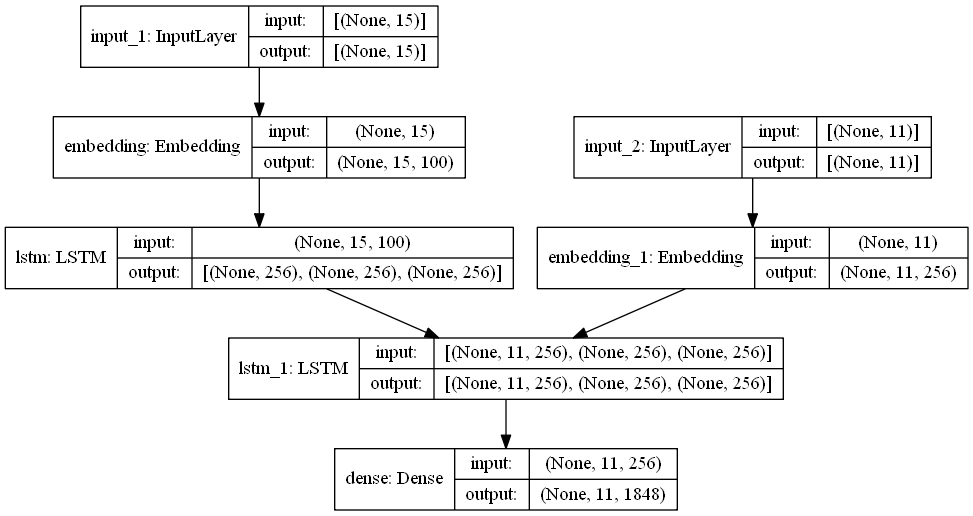

In [46]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

## fitting the model

In [47]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20
31/31 [==============================] - 4s 29ms/step - loss: 3.7145 - accuracy: 0.4551 - val_loss: 4.5642 - val_accuracy: 0.2901
Epoch 2/20
31/31 [==============================] - 0s 14ms/step - loss: 2.9603 - accuracy: 0.5357 - val_loss: 4.5233 - val_accuracy: 0.3479
Epoch 3/20
31/31 [==============================] - 0s 14ms/step - loss: 2.7959 - accuracy: 0.5674 - val_loss: 4.3485 - val_accuracy: 0.3537
Epoch 4/20
31/31 [==============================] - 0s 14ms/step - loss: 2.6659 - accuracy: 0.5749 - val_loss: 4.4594 - val_accuracy: 0.3599
Epoch 5/20
31/31 [==============================] - 0s 14ms/step - loss: 2.5458 - accuracy: 0.5837 - val_loss: 4.3791 - val_accuracy: 0.3777
Epoch 6/20
31/31 [==============================] - 0s 14ms/step - loss: 2.4383 - accuracy: 0.5920 - val_loss: 4.4658 - val_accuracy: 0.3806
Epoch 7/20
31/31 [==============================] - 0s 14ms/step - loss: 2.3368 - accuracy: 0.5993 - val_loss: 4.2664 - val_accuracy: 0.3905
Epoch 8/20
31